In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from datetime import datetime
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    silhouette_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    f1_score, 
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    precision_score, 
    recall_score
)
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import IsolationForest
from scipy.optimize import linear_sum_assignment

from sklearn.preprocessing import LabelEncoder

In [2]:
TRAIN_DATASET_PATH = 'Dataset/train_data.csv'
TARGET_COLUMN = 'Label'
columns_to_drop = ['FlowID', 'SourceIP', 'DestinationIP', 'Timestamp']

In [3]:
# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')
    
# Create plots directory if it doesn't exist
if not os.path.exists('plots'):
    os.makedirs('plots')

In [4]:
# Load and preprocess data
df = pd.read_csv(TRAIN_DATASET_PATH)
df = df.drop(columns=columns_to_drop, errors='ignore')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Stratified downsampling
desired_sample_size = 30000
sample_frac = desired_sample_size / len(df) 

df, _ = train_test_split(
    df,
    test_size=1 - sample_frac,
    stratify=df[TARGET_COLUMN],
    random_state=42
)

In [6]:
# Check class distribution
print(f"Total records: {len(df)}")
print("Class distribution:")
print(df[TARGET_COLUMN].value_counts(normalize=True))

# Print raw label counts
print("Raw label counts:")
print(df[TARGET_COLUMN].value_counts())

Total records: 30000
Class distribution:
Label
BENIGN              0.773467
PortScan            0.099233
DoS Hulk            0.071867
DDoS                0.040000
FTP-Patator         0.005000
SSH-Patator         0.003700
DoS GoldenEye       0.003200
DoS slowloris       0.001800
DoS Slowhttptest    0.001733
Name: proportion, dtype: float64
Raw label counts:
Label
BENIGN              23204
PortScan             2977
DoS Hulk             2156
DDoS                 1200
FTP-Patator           150
SSH-Patator           111
DoS GoldenEye          96
DoS slowloris          54
DoS Slowhttptest       52
Name: count, dtype: int64


In [5]:
# Separate features and target
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

def simplify_labels(y):
    return y.apply(lambda x: 'BENIGN' if x.upper() == 'BENIGN' else 'ATTACK')

y = simplify_labels(y)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Check encoded target distribution
print("Encoded target distribution:")
print(pd.Series(y_encoded).value_counts(normalize=True))
# Check encoded label mapping
print("Encoded label mapping:")
for original, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{original}: {encoded}")

Encoded target distribution:
1    0.773467
0    0.226533
Name: proportion, dtype: float64
Encoded label mapping:
ATTACK: 0
BENIGN: 1


In [6]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# save scaler
scaler_filename = 'unsupervised_scaler.pkl'
joblib.dump(scaler, scaler_filename)

['unsupervised_scaler.pkl']

In [12]:
# Define evaluation functions
def map_clusters_to_labels(y_true, y_pred):
    """
    Map cluster IDs to true class labels by maximizing the overlap
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels
    y_pred : array-like
        Cluster assignments from unsupervised model
        
    Returns:
    --------
    mapped_pred : array-like
        Cluster labels mapped to match true labels
    """
    # Create contingency matrix
    contingency = np.zeros((len(np.unique(y_pred)), len(np.unique(y_true))))
    for i, pred_label in enumerate(np.unique(y_pred)):
        for j, true_label in enumerate(np.unique(y_true)):
            contingency[i, j] = np.sum((y_pred == pred_label) & (y_true == true_label))
    
    # Use Hungarian algorithm to find optimal mapping
    row_ind, col_ind = linear_sum_assignment(-contingency)
    
    # Create mapping dictionary
    cluster_to_label = {np.unique(y_pred)[i]: np.unique(y_true)[j] 
                       for i, j in zip(row_ind, col_ind)}
    
    # Map each prediction to its corresponding true label
    mapped_pred = np.array([cluster_to_label.get(label, -1) for label in y_pred])
    
    return mapped_pred

def plot_confusion_matrix(y_true, y_pred, model_name=None):
    """
    Plot a confusion matrix for the results
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels
    y_pred : array-like
        Predicted labels after mapping
    model_name : str, default=None
        Name of the model for plot title
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['ATTACK', 'BENIGN'],
                yticklabels=['ATTACK', 'BENIGN'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    title = 'Confusion Matrix'
    if model_name:
        title += f' for {model_name}'
    plt.title(title)
    plt.tight_layout()
    
    # Save plot if model name is provided
    if model_name:
        plt.savefig(f'plots/confusion_matrix_{model_name}.png', dpi=300, bbox_inches='tight')
    
    plt.show()

def save_clustering_model(model, model_name):
    """
    Save a trained clustering model to disk in .pkl format.

    Parameters:
    -----------
    model : sklearn clustering model
        The fitted model to save
    model_name : str
        Name of the model for filename
    """
    # Ensure models directory exists
    os.makedirs("models", exist_ok=True)

    # Latest version overwrite
    latest_filename = f'models/{model_name}_latest.pkl'
    with open(latest_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Latest model saved to {latest_filename}")

def evaluate_clusters(X, y_true, model, show_confusion_matrix=False, model_name=None, save_model=False):
    """
    Evaluate clustering models with both clustering metrics and classification metrics
    after mapping cluster IDs to actual class labels.
    
    Parameters:
    -----------
    X : array-like
        Features used for clustering
    y_true : array-like
        True binary labels (0 for BENIGN, 1 for attacks)
    model : sklearn clustering model
        The clustering model to evaluate
    show_confusion_matrix : bool, default=False
        Whether to display confusion matrix visualization
    model_name : str, default=None
        Name of the model for plot title
    save_model : bool, default=False
        Whether to save the fitted model to disk
        
    Returns:
    --------
    y_pred : array-like
        Mapped cluster predictions
    metrics : dict
        Dictionary of evaluation metrics
    """
    # Get clustering predictions
    y_pred_raw = model.fit_predict(X)
    
    # Calculate clustering metrics
    metrics = {
        'ARI': adjusted_rand_score(y_true, y_pred_raw),
        'NMI': normalized_mutual_info_score(y_true, y_pred_raw),
        'Silhouette': silhouette_score(X, y_pred_raw) if len(set(y_pred_raw)) > 1 else -1,
        'Homogeneity': homogeneity_score(y_true, y_pred_raw),
        'Completeness': completeness_score(y_true, y_pred_raw),
        'V-Measure': v_measure_score(y_true, y_pred_raw),
        'NumClusters': len(set(y_pred_raw))
    }
    
    # Map clusters to classes for classification metrics
    y_pred_mapped = map_clusters_to_labels(y_true, y_pred_raw)
    
    # Calculate classification metrics with the mapped labels
    metrics['Accuracy'] = accuracy_score(y_true, y_pred_mapped)
    metrics['Precision'] = precision_score(y_true, y_pred_mapped, average='weighted', zero_division=0)
    metrics['Recall'] = recall_score(y_true, y_pred_mapped, average='weighted', zero_division=0)
    metrics['F1_Score'] = f1_score(y_true, y_pred_mapped, average='weighted', zero_division=0)

    
    # Generate class-specific F1 scores
    class_report = classification_report(y_true, y_pred_mapped, output_dict=True)
    for label, stats in class_report.items():
        if isinstance(stats, dict) and 'f1-score' in stats:
            metrics[f'F1_Class_{label}'] = stats['f1-score']
    
    # Calculate true positive rate (TPR) and false positive rate (FPR)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_mapped).ravel()
    metrics['TPR'] = tp / (tp + fn)  # Sensitivity/Recall
    metrics['FPR'] = fp / (fp + tn)  # Fall-out
    
    # Display confusion matrix if requested
    if show_confusion_matrix:
        plot_confusion_matrix(y_true, y_pred_mapped, model_name)
    
    # Save the model if requested
    if save_model and model_name:
        save_clustering_model(model, model_name)
    
    return y_pred_mapped, metrics

In [8]:
# Define models to evaluate
models = {
    'KMeans_k2': KMeans(n_clusters=2, random_state=42),
    'Agglomerative_k2': AgglomerativeClustering(n_clusters=2),
    'IsolationForest' : IsolationForest(contamination=0.2, random_state=42)
}


Running KMeans_k2...


C:\Users\jeffc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


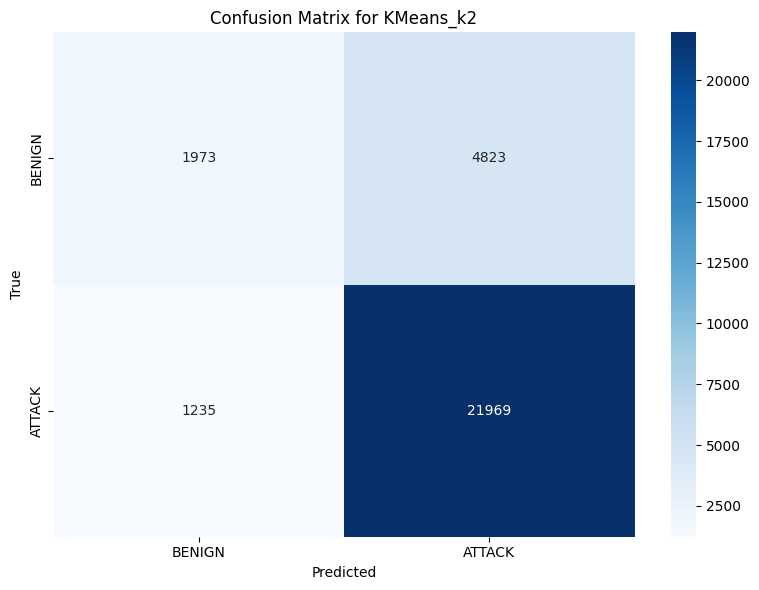

Latest model saved to models/KMeans_k2_latest.pkl
ARI: 0.2092
NMI: 0.0978
Silhouette: 0.5757
Homogeneity: 0.0800
Completeness: 0.1258
V-Measure: 0.0978
NumClusters: 2
Accuracy: 0.7981
Precision: 0.7736
Recall: 0.7981
F1_Score: 0.7691
F1_Class_0: 0.3944
F1_Class_1: 0.8788
F1_Class_macro avg: 0.6366
F1_Class_weighted avg: 0.7691
TPR: 0.9468
FPR: 0.7097

Running Agglomerative_k2...


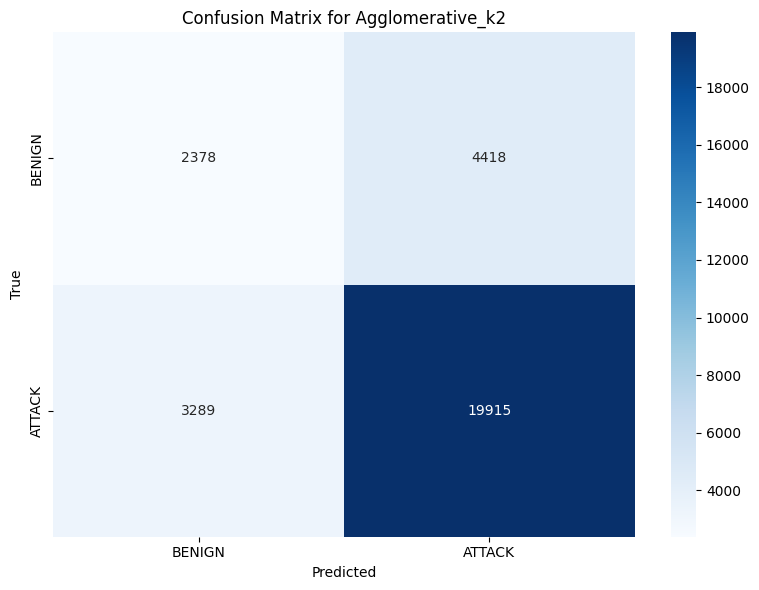

Latest model saved to models/Agglomerative_k2_latest.pkl
ARI: 0.1364
NMI: 0.0437
Silhouette: 0.4683
Homogeneity: 0.0417
Completeness: 0.0460
V-Measure: 0.0437
NumClusters: 2
Accuracy: 0.7431
Precision: 0.7281
Recall: 0.7431
F1_Score: 0.7345
F1_Class_0: 0.3816
F1_Class_1: 0.8379
F1_Class_macro avg: 0.6097
F1_Class_weighted avg: 0.7345
TPR: 0.8583
FPR: 0.6501

Running IsolationForest...


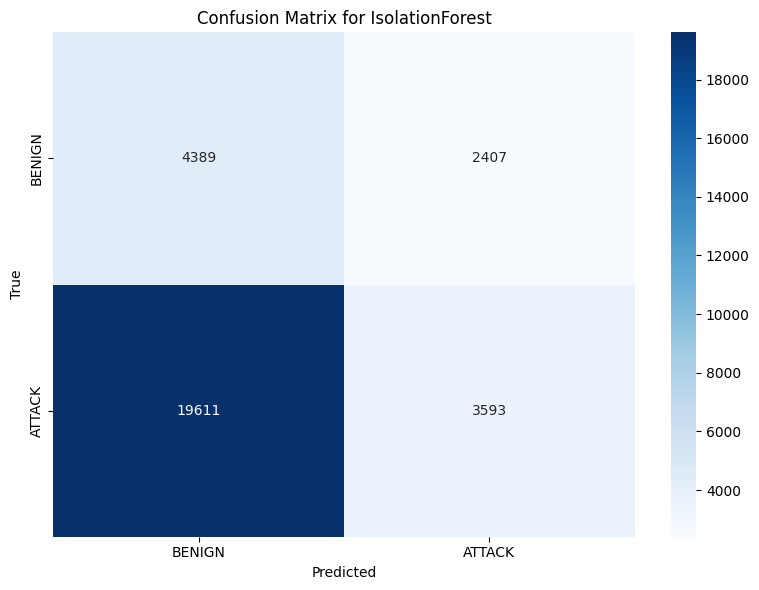

Latest model saved to models/IsolationForest_latest.pkl
ARI: 0.1246
NMI: 0.0382
Silhouette: -1
Homogeneity: 0.0370
Completeness: 0.0395
V-Measure: 0.0382
NumClusters: 2
Accuracy: 0.2661
Precision: 0.5046
Recall: 0.2661
F1_Score: 0.2549

Model Performance Summary:


,ARI,Accuracy,Completeness,F1_Class_0,F1_Class_1,F1_Class_macro avg,F1_Class_weighted avg,F1_Score,FPR,Homogeneity,NMI,NumClusters,Precision,Recall,Silhouette,TPR,V-Measure
Model,,,,,,,,,,,,,,,,,
KMeans_k2,0.2092,0.7981,0.1258,0.3944,0.8788,0.6366,0.7691,0.7691,0.7097,0.0800,0.0978,2,0.7736,0.7981,0.5757,0.9468,0.0978
Agglomerative_k2,0.1364,0.7431,0.0460,0.3816,0.8379,0.6097,0.7345,0.7345,0.6501,0.0417,0.0437,2,0.7281,0.7431,0.4683,0.8583,0.0437
IsolationForest,0.1246,0.2661,0.0395,NaN,NaN,NaN,NaN,0.2549,NaN,0.0370,0.0382,2,0.5046,0.2661,-1.0000,NaN,0.0382


Results saved to clustering_results.csv


In [20]:
results = {}
labels_by_model = {}
result_df_data = []

for name, model in models.items():
    print(f"\nRunning {name}...")

    if isinstance(model, IsolationForest):
        # Use .fit_predict(), then map -1 to 1 (attack), 1 to 0 (benign)
        y_pred_raw = model.fit_predict(X_scaled)
        y_mapped = (y_pred_raw == -1).astype(int)

        # Evaluate metrics directly (no cluster mapping)
        metrics = {
            'ARI': adjusted_rand_score(y_encoded, y_mapped),
            'NMI': normalized_mutual_info_score(y_encoded, y_mapped),
            'Silhouette': -1,  # not meaningful
            'Homogeneity': homogeneity_score(y_encoded, y_mapped),
            'Completeness': completeness_score(y_encoded, y_mapped),
            'V-Measure': v_measure_score(y_encoded, y_mapped),
            'NumClusters': len(set(y_mapped)),
            'Accuracy': accuracy_score(y_encoded, y_mapped),
            'Precision': precision_score(y_encoded, y_mapped, average='weighted'),
            'Recall': recall_score(y_encoded, y_mapped, average='weighted'),
            'F1_Score': f1_score(y_encoded, y_mapped, average='weighted')
        }

        # Optional: save confusion matrix and model
        plot_confusion_matrix(y_encoded, y_mapped, model_name=name)
        save_clustering_model(model, name)

    else:
        # Normal case for other models
        y_mapped, metrics = evaluate_clusters(
            X_scaled, 
            y_encoded, 
            model,
            show_confusion_matrix=True,
            model_name=name,
            save_model=True
        )

    results[name] = metrics
    labels_by_model[name] = y_mapped

    # Store for DataFrame
    metrics_copy = metrics.copy()
    metrics_copy['Model'] = name
    result_df_data.append(metrics_copy)

    # Print metrics
    for k, v in metrics.items():
        if isinstance(v, float):
            print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: {v}")

# Build result DataFrame
result_df = pd.DataFrame(result_df_data)
sorted_cols = ['Model'] + sorted([c for c in result_df.columns if c != 'Model'])
result_df = result_df[sorted_cols]

print("\nModel Performance Summary:")
display(result_df.set_index('Model').round(4))

# Save to CSV
result_df.to_csv('clustering_results.csv', index=False)
print("Results saved to clustering_results.csv")


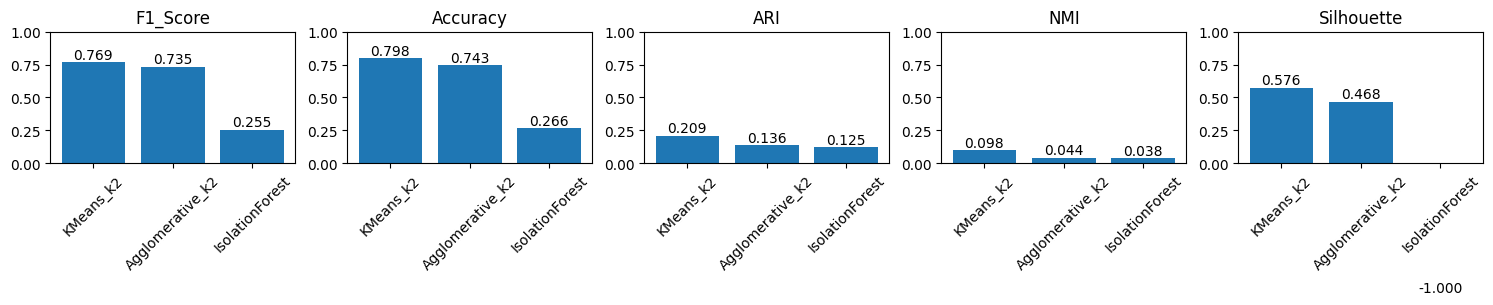

In [21]:
# Create visualization of key metrics
plt.figure(figsize=(15, 8))
metrics_to_plot = ['F1_Score', 'Accuracy', 'ARI', 'NMI', 'Silhouette']
model_names = list(models.keys())

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(1, len(metrics_to_plot), i+1)
    values = [results[model][metric] for model in model_names]
    bars = plt.bar(model_names, values)
    plt.title(metric)
    plt.ylim(0, max(max(values)*1.1, 1.0))
    plt.xticks(rotation=45)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('plots/clustering_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


=== KMeans_k2 Test Set Evaluation ===
Classification Report:
              precision    recall  f1-score   support

      ATTACK       0.62      0.30      0.40    145426
      BENIGN       0.82      0.95      0.88    494269

    accuracy                           0.80    639695
   macro avg       0.72      0.62      0.64    639695
weighted avg       0.77      0.80      0.77    639695



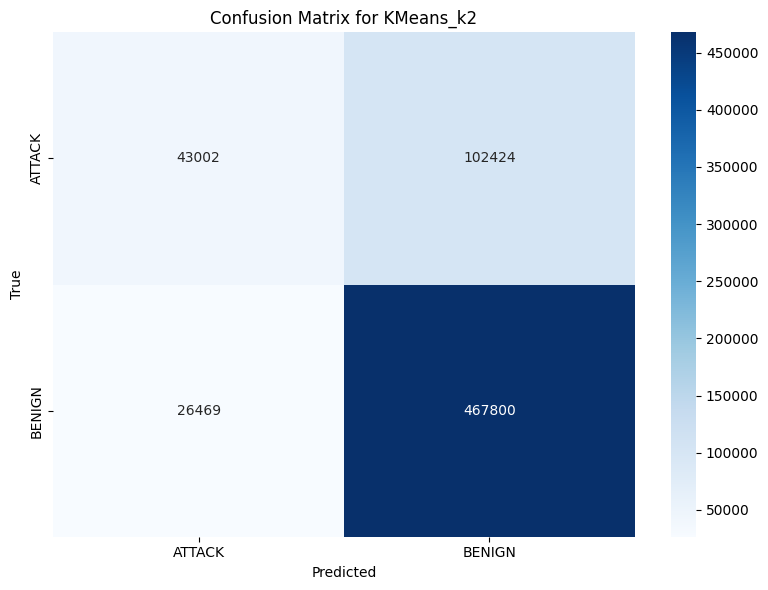

In [13]:
# Load test data
test_path = 'Dataset/test_data.csv'
test_df = pd.read_csv(test_path)

# Drop unnecessary columns and handle missing values
test_df = test_df.drop(columns=columns_to_drop, errors='ignore')
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.fillna(0, inplace=True)

# Extract features and true labels
X_test = test_df.drop(columns=[TARGET_COLUMN])
y_test = simplify_labels(test_df[TARGET_COLUMN])
y_test_encoded = label_encoder.transform(y_test)

# Load previously saved scaler and model
scaler = joblib.load('unsupervised_scaler.pkl')
X_test_scaled = scaler.transform(X_test)

with open('models/KMeans_k2_latest.pkl', 'rb') as f:
    kmeans_model = pickle.load(f)

# Predict clusters on test data
y_pred_clusters = kmeans_model.predict(X_test_scaled)

# Map cluster IDs to labels using the training-set-based mapping function
y_pred_mapped = map_clusters_to_labels(y_test_encoded, y_pred_clusters)

# Evaluate
print("\n=== KMeans_k2 Test Set Evaluation ===")
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_mapped, target_names=label_encoder.classes_))

# Plot confusion matrix
plot_confusion_matrix(y_test_encoded, y_pred_mapped, model_name='KMeans_k2')
